In [1]:
import cartopy.crs as ccrs
import earthaccess
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

I am interested in analysies Remote Sensing Reflectance (Rrs).
I need level 2 product, with variables Apparent Optical Properties (AOPs) 

In [2]:
auth = earthaccess.login(persist=True)

To find proper short name of nedded product 

In [4]:
results = earthaccess.search_datasets(instrument="oci")
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_BGC_NRT
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_PAR_NRT
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_IOP_NRT
PACE_OCI_L3M_KD_NRT
PACE_OCI_L3M_PAR_NRT
PACE_OCI_L3M_POC_NRT
PACE_OCI_L3M_RRS_NRT


PACE data scene cover quite big pieces of continent. I find cloud cover as ineffective search parameter. I search for small region without cloud cover, but afterwards exclude files with small size (<100 MB)
Looking for area close to Lofoten Island (Norway)

In [6]:
tspan = ("2024-05-02", "2024-05-07")
bbox = (13.5, 68.0, 14.5, 69.0)

results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP_NRT",
    temporal=tspan,
    bounding_box=bbox,
)

fresults = []
for i in results:
    if i.size() > 100:
        fresults.append(i)
print(f"Total numer of files: {len(results)}, files bigger then 100MB:  {len(fresults)}")
print(fresults[0:])

Total numer of files: 39, files bigger then 100MB:  5
[Collection: {'Version': '2.0', 'ShortName': 'PACE_OCI_L2_AOP_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 76.8861, 'Longitude': 22.20306}, {'Latitude': 65.84284, 'Longitude': -54.242}, {'Latitude': 52.53471, 'Longitude': -28.3678}, {'Latitude': 59.53616, 'Longitude': 14.19732}, {'Latitude': 76.8861, 'Longitude': 22.20306}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-05-02T12:43:08Z', 'EndingDateTime': '2024-05-02T12:48:07Z'}}
Size(MB): 104.55436515808105
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240502T124308.L2.OC_AOP.V2_0.NRT.nc'], Collection: {'ShortName': 'PACE_OCI_L2_AOP_NRT', 'Version': '2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 77.13168, 'Longitude': 38.40392}, {'Latitude': 66.0153, 'Longitude': -38.87184}, {'

In [7]:
files = earthaccess.download(fresults, "./PACE_Lofoten_May")

QUEUEING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/5 [00:00<?, ?it/s]

To quickly check how looks the data, for each file plot on map RRS (band 555 nm). Cut the data to area of intrest

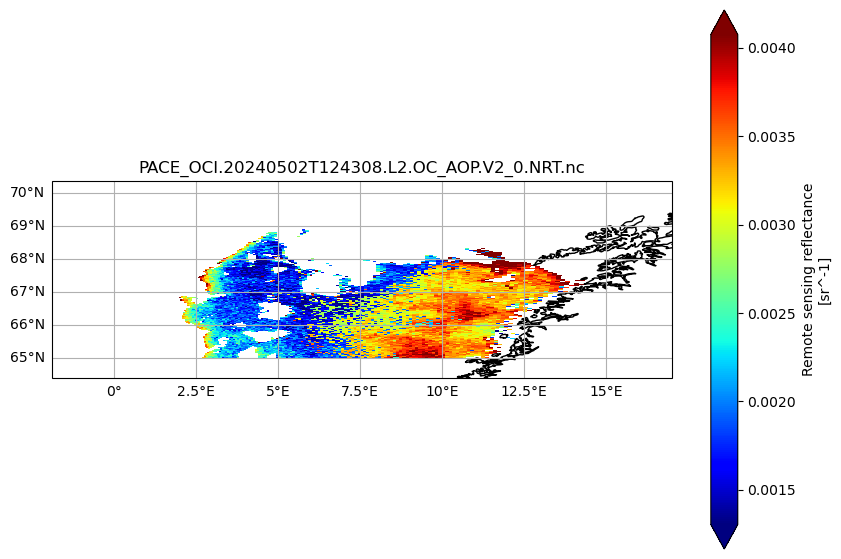

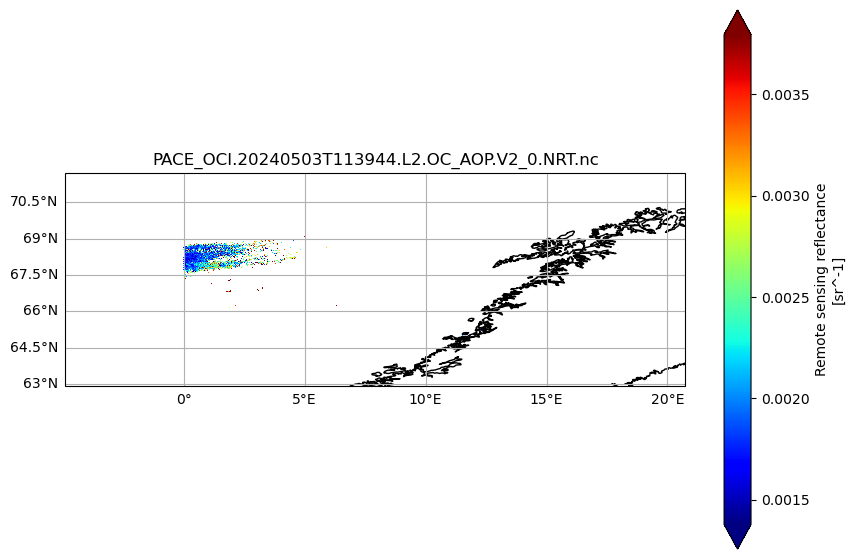

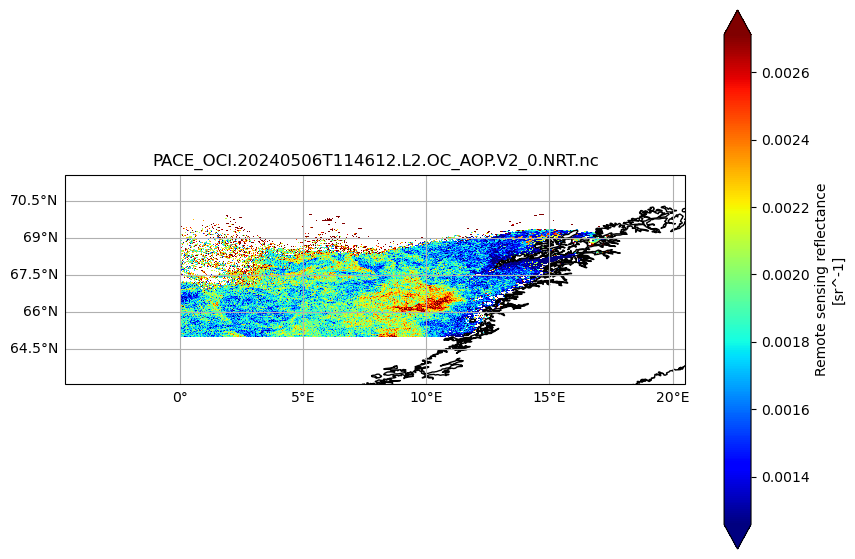

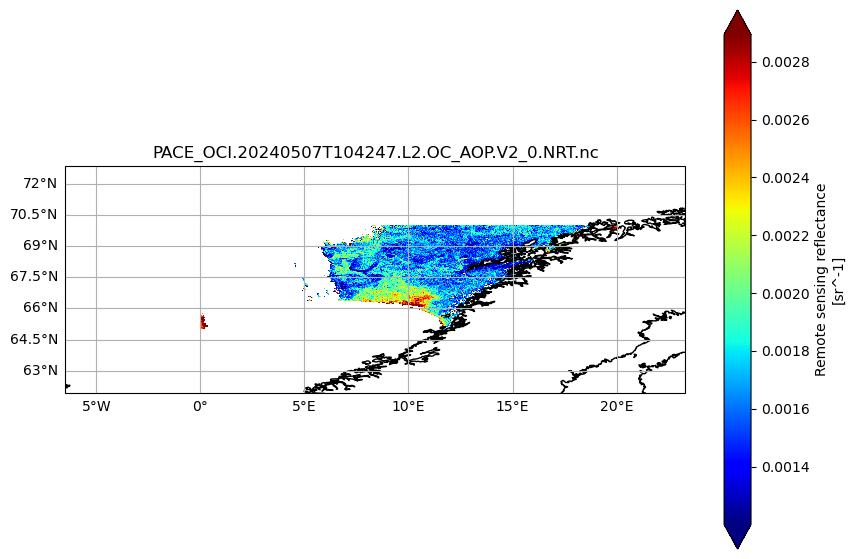

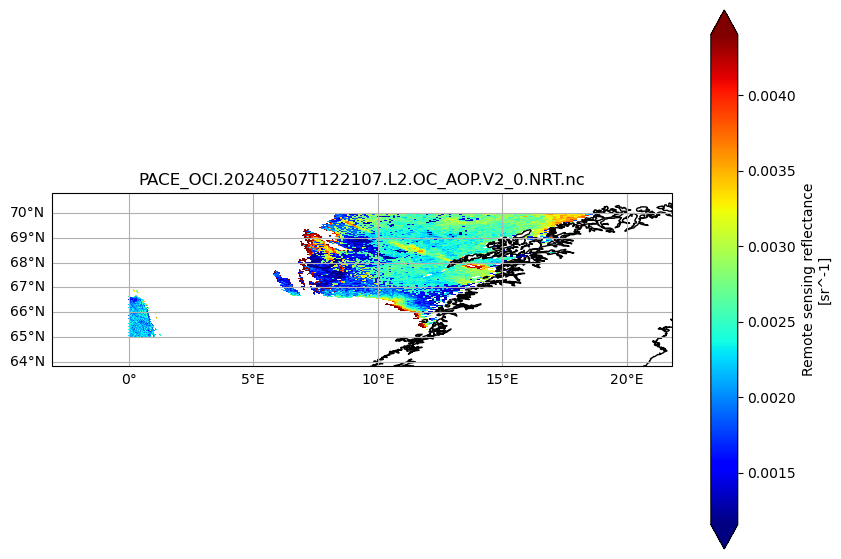

In [9]:
for file in files:
    prod = xr.open_dataset(file)
    obs = xr.open_dataset(file, group="geophysical_data")
    nav = xr.open_dataset(file, group="navigation_data")

    nav = nav.set_coords(("longitude", "latitude"))
    rrs = obs["Rrs"]
    dataset = xr.merge((prod, rrs, nav.coords))

    array = dataset["Rrs"].sel({"wavelength_3d": 87}).where(
        (
            (dataset["latitude"] > 65)
            & (dataset["latitude"] < 70)
            & (dataset["longitude"] > 0)
            & (dataset["longitude"] < 20)
        ),
        drop=True,
    )
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    array.plot(x="longitude", y="latitude", cmap="jet", robust=True, ax=ax)
    ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
    ax.set_title(dataset.attrs["product_name"], loc="center")
    plt.show()

I can exclude one scene (date: 03.05.24) from further analyses. To create map a will use SEADAS (NASA)